# Data preparation:

Creates:
- monthly RCMs concatenated with all variables
- GCM like monthly RCM with all variables
- GCM with same variables as in RCM and same time-frame

## Setting up:

In [1]:
# run script that installs missing libraries
! chmod 755 ../../scripts.sh
! ../../scripts.sh

  Using cached cf_units-3.0.1.post0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (491 kB)
  Using cached antlr4_python3_runtime-4.7.2-py3-none-any.whl
  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.7.5
    Uninstalling python-dateutil-2.7.5:
      Successfully uninstalled python-dateutil-2.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sat-stac 0.4.1 requires python-dateutil~=2.7.5, but you have python-dateutil 2.8.2 which is incompatible.
intake-esm 2021.8.17 requires h5netcdf>=0.8.1, but you have h5netcdf 0.0.0 which is incompatible.
earthdata 0.2.2 requires python-benedict<0.26,>=0.25, but you have python-benedict 0.24.3

In [2]:
import os
import sys

from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join
from scipy import ndimage

# import self made python files

sys.path.append('../')
from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Google cloud
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

os.environ["GCLOUD_PROJECT"] = PROJECT
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

In [4]:
def plotAllVar(GCM_xy, m=3, n=3, name='GCM'):
    vars_ = list(GCM_xy.data_vars)
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(20, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, i + 1, projection=ccrs.SouthPolarStereo())
        GCM_xy[var].isel(time=0).plot(ax=ax, x='x', y='y',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
        ax.coastlines('10m', color='black')
        ax.gridlines(draw_labels=False)
        ax.set_title(f'{GCM_xy[var].long_name} ({var})')
    plt.suptitle(f'First time step {GCM_xy.time[0].values} of {name}')

## Read data:

### Monthly GCM xy: 
GCM projected from lat/lon to polar stereographic coordinates. 

#### Vars GCM:

For precipitation conversion: 1 kg/m2/s = 86400 mm/day.
Pressure level: near surface --> 925 Hpa

- **pr**: precipitation [kg m-2 s-1] --> need to change to  [mmWE/day], eq: **RF+SF?**
- **psl**: sea level pressure [Pa] --> need to change to [hPa], eq: **SP**
- **rlut**: outgoing longwave radiation [W/m2], eq: **LWD**
- **rsut**: outgoing shortwave radiation [W/m2], eq: **SWD**
- **rsdt**: incident shortwave radiation [W/m2]
- **tas**: near surface air temp [K] --> need to change to [°C], eq: **TT**
- **uas**: eastward near surface wind [m/s], eq: **UUP** at surface pressure (PLEV:7)
- **vas**: northward near surface wind [m/s], eq: **VVP** at surface pressure (PLEV:7)


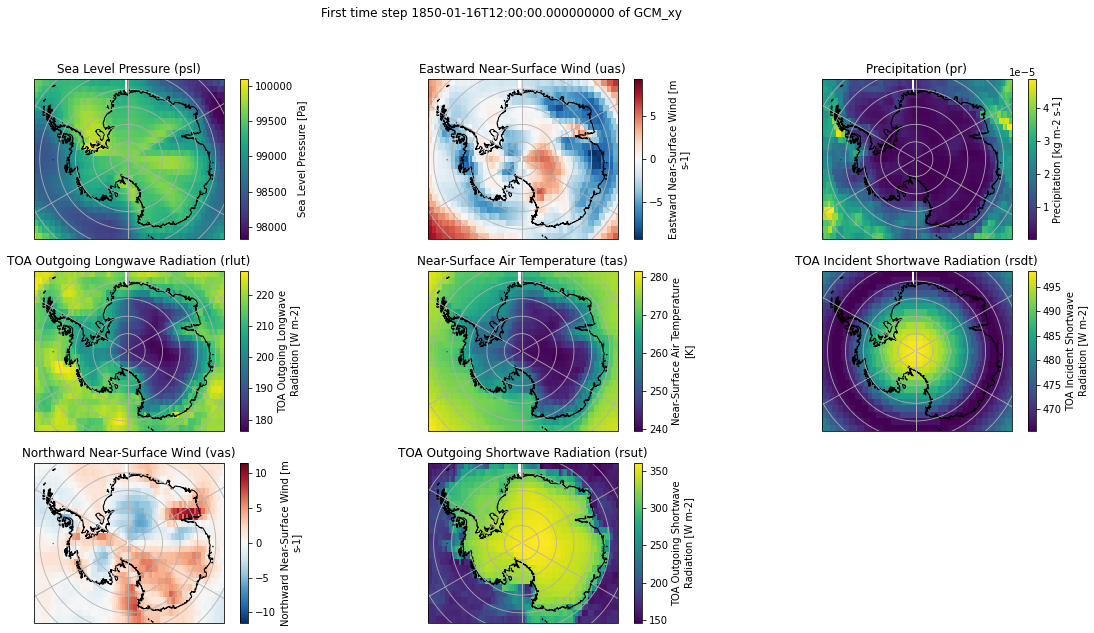

In [5]:
# open from google cloud
# open from google cloud

customGrid = False
resx, resy = 90, 32

if customGrid:
    fileGC = f'ACCESS1-3-stereographic_monthly_{resx}x{resy}.nc'
else:
    fileGC = 'ACCESS1-3-stereographic_monthly.nc'

# download from GC:
print(f'Downloading {fileGC} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
downloadFileFromGC(pathGC, '', fileGC)

GCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)
GCM_xy_plot = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds','spatial_ref'])
plotAllVar(GCM_xy_plot, m=3, n=3, name='GCM_xy')

### RCM xy:
#### Vars RCM: 

PLEVLS: [200., 500., 600., 700., 800., 850., 925.]

ATMLAY: [0.99892 , 0.999325, 0.99973]

Atmosphere: 
- CC: Cloud Cover
- QQP: Specific Humidity [g/kg] (for 7 PLEV)
- RH: Relative Humidity [%] (ATMLAY: 3)

Water mass processes: 
- ME: Meltwater production [mmWE/day] (SECTOR1_1: 1)
- **RF**: Rainfall [mmWE/day] -> [mm/day]
- RU: Run-off of meltwater and rain water [mmWE/day] (SECTOR: 1)
- SF: Snowfall [mmWE/day]
- SMB: Surface Mass Balance (SMB~SF+RF-RU-SU-SW) [mmWE/day] (SECTOR: 1)
- SU: Sublimation and evaporation [mmWE/day] (SECTOR: 1)

Temperature: 
- **TT**: Temperature [°C] (ATMLAY:1, 0.9997)
- TTP: Temperature [°C] (PLEV: 7)

Pressure: 
- **SP**: Surface Pressure [hPa]

Radiation: 
- **SWD**: Short Wave Downward [W/m2]
- **LWD**: Long  Wave Downward [W/m2]

Wind speeds:
- **UUP**: x-Wind Speed component [m/s] (PLEV: 7)
- **VVP**: y-Wind Speed component [m/s] (PLEV: 7)

#### One time step:

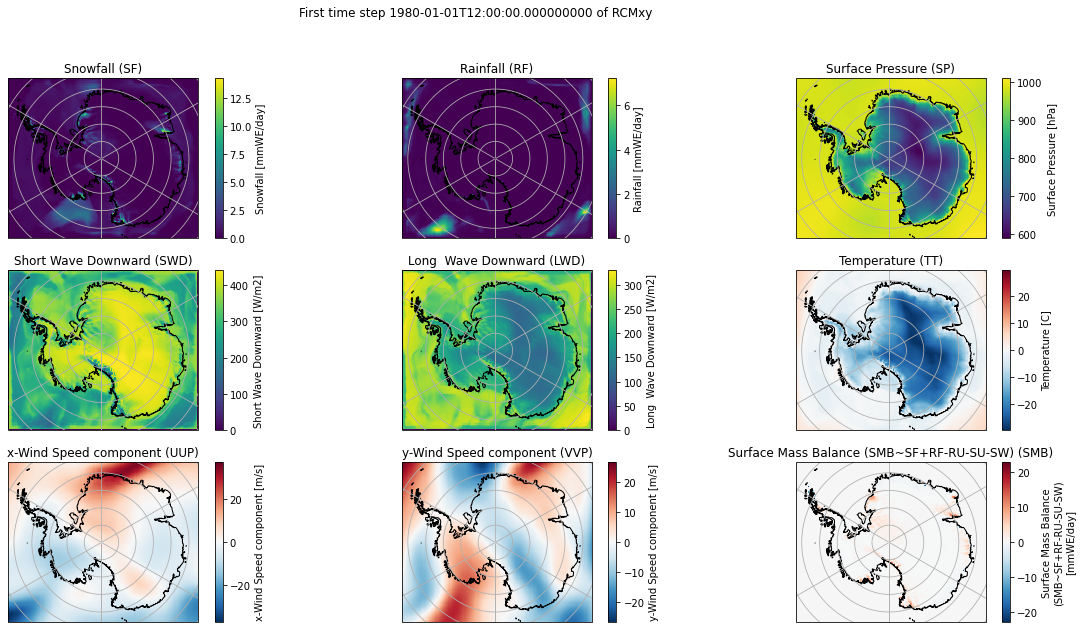

In [6]:
# Select variables that are also in GCM: 

# Rainfall: 
VAR = 'RF'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
rf = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# Snowfall: 
VAR = 'SF'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
sf = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# sea level pressure: 
VAR = 'SP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
sp = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# radiations:
VAR = 'SWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
swd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

VAR = 'LWD'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
lwd = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# near surface air temp:
VAR = 'TT'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
tt = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# wind at surface level (PLEV:0)
VAR = 'UUP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
uup = ProcessRCMVar(VAR, xr.open_dataset(fileGC)).isel(PLEV=0)
os.remove(fileGC)

VAR = 'VVP'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
vvp = ProcessRCMVar(VAR, xr.open_dataset(fileGC)).isel(PLEV=0)
os.remove(fileGC)

# SMB: 
VAR = 'SMB'
pathGC, fileGC = pathToFiles(VAR, date1='19800101', date2='19801231')
downloadFileFromGC(pathGC, '', fileGC)
smb = ProcessRCMVar(VAR, xr.open_dataset(fileGC))
os.remove(fileGC)

# Put together all variables:
RCMxy = xr.merge([sf, rf, sp, swd, lwd, tt, uup, vvp, smb])

# Basic pre-processing
RCMxy = BasicPreprocRCM(RCMxy)

plotAllVar(RCMxy, m=3, n=3, name='RCMxy')

## Preprocessing: 

### RCM 
#### Resample to monthly freq and save:

In [7]:
vars_ = ['SF','RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP', 'SMB']
download = False
if download:
    ! rm -r ../../../data/tmp/*
    for VAR in vars_:
        print(f'{VAR}:\n--------------')
        pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/{VAR}/'
        pathLocal = '../../../data/tmp/'
        filesGC = listFilesGC(pathGC, VAR)

        #------ Download files from GC
        print('Downloading files from GC')
        downloadFilesFromGC(pathGC, pathLocal, filesGC)

        onlyfiles = filesInDirWithVar(pathLocal, VAR)
        print('Examples of files: \n {}'.format(onlyfiles[0]))

        #------ concatenate all years of a variable
        # first year
        if len(onlyfiles) == 121:
            print('Concatenating...')
            f0 = onlyfiles[0]
            df0 = xr.open_dataset(pathLocal+f0)
            # preprocessing and resampling
            df0 = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df0)))

            for f in onlyfiles[1:]:
                df = xr.open_dataset(pathLocal+f)
                # preprocessing and resampling
                df = resampleMonthlyMean(BasicPreprocRCM(ProcessRCMVar(VAR, df)))

                # concatenate with previous years
                df0 = xr.concat([df0,df], dim = 'time')

            # save file locally:
            path = '../../data/toGC/'
            name = f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc'
            df0.to_netcdf(name)

            # upload to GC:
            print('Uploading to GC...')
            print(name)
            pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
            uploadFileToGC(pathGC, name)

            # delete file and temporary directory:
            os.remove(name)
            ! rm ../../../data/tmp/*

        else:
            print(f'Error: len only files is:{len(onlyfiles)}')
            break
            
    # test:
    f = plt.figure(figsize=(10, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
    df0.isel(time = 1)[vars_[0]].plot(ax=ax, x='x', y='y',transform=ccrs.SouthPolarStereo())
    ax.coastlines('10m', color='black')
    ax.gridlines()

#### Concatenate all variables:

In [8]:
vars_ = ['SF','RF', 'SP', 'LWD', 'SWD', 'TT', 'UUP', 'VVP', 'SMB']
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'
pathLocal = '../../../data/tmp/'

download = False
if download:
    # names of files on GC
    
    vars_wo_wind = ['SF','RF', 'SP', 'LWD', 'SWD', 'TT', 'SMB']
    filesGC = [f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly.nc' for VAR in vars_wo_wind]
    
    # Need to load winds that have been processed to last non nan values per plvls
    vars_w_wind = ['VVP', 'UUP']
    filesGCWind = [f'{VAR}_ant-35km_ACCESS1.3_rcp8.5_r1i1p1_ULg-MAR311_v1_monthly_spwinds.nc' for VAR in vars_w_wind]
    
    filesGC = filesGC+filesGCWind
    
    # download files and store locally
    downloadFilesFromGC(pathGC, pathLocal, filesGC)

    # concatenate and save nc file to GC
    f0 = filesGC[0]
    df0 = xr.open_dataset(pathLocal+f0)

    for f1 in filesGC[1:]:
        df1 = xr.open_dataset(pathLocal+f1)
        
        """
        if 'SMB' in f1:
            dim = ('time', 'y', 'x')
            df1['SMB'] = xr.Variable(dims = dim, 
                                        data = df1.SMB.mean(dim='SECTOR'), 
                                        attrs = df1.SMB.attrs)
            df1 = df1.drop_dims(['SECTOR'])"""
        df0 = xr.merge([df0,df1])

    # save file locally:
    name = f'MAR(ACCESS1-3)_monthly.nc'
    df0.to_netcdf(name)

    # upload to GC:
    print('Uploading to GC...')
    pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
    uploadFileToGC(pathGC, name)

    # delete file and temporary directory:
    os.remove(name)
    ! rm ../../../data/tmp/*

    # test:
    plotAllVar(df0, m=3, n=3, name='RCM_xy')

#### Change RCM winds:

In [10]:
# upload to GC:
print('Downloading from GC...')
name = f'MAR(ACCESS1-3)_monthly.nc'
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
downloadFileFromGC(pathGC, '', name)

RCM = xr.open_dataset(name)
os.remove(name)


In [12]:
RCM

<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 176, PLEV: 7)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    SF           (time, y, x) float32 ...
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:44:39 2022: ncap2 -O -s SF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

In [17]:
import math
GEddxx = 90
deltaphi = 90 - GEddxx
dr = math.pi/180

mx = RCM.dims['x']
my = RCM.dims['y']

for i in mx:
    for j in my:
        lonmar(i,j)=gelonh(i,j)*15 
        phi = (-1.) * (lonmar(i,j)+deltaphi)*dr
        cphi = cos(-phi)
        sphi = sin( -phi )

integer i,j
real dr, deltaphi,phi,cphi,sphi
real lonmar(mx,my)
real uurot(mx,my),vvrot(mx,my),ux(mx,my),vy(mx,my)

dr = degrad !pi/180.


deltaphi = 90. - GEddxx !Geddxx= 90 in my config

ux=uurot !uu
vy=vvrot !vv
do j=1,my ; do i=1,mx
lonmar(i,j)=gelonh(i,j) *15.d0 !longitude (in the MAR code, the lon is expressed in hours, so you can directly use the longitude in ° here)
phi = (-1.) * (lonmar(i,j)+deltaphi)*dr
cphi = cos( -phi )
sphi = sin( -phi )
ux(i,j) = cphi*uurot(i,j) - sphi*vvrot(i,j)
vy(i,j) = sphi*uurot(i,j) + cphi*vvrot(i,j)
enddo; enddo

=> ux and uv are you wind directions Northward and Eastward.

### GCM:
So that is similar to RCM

In [9]:
# open from google cloud
resx, resy = 90, 32
fileGC = 'ACCESS1-3-stereographic_monthly.nc'

# upload to GC:
print(f'Downloading {fileGC} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
downloadFileFromGC(pathGC, '', fileGC)

GCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)

GCM_xy = GCM_xy.rio.write_crs("epsg:3031")
GCM_xy.attrs['crs'] = 3031

# Slice to same time as RCM:
Firstdate = datetime(1980,1,16, 12, 0,0)
Enddate = datetime(2100,12,16, 12, 0,0)

GCM_xy = GCM_xy.sel(time = slice(Firstdate, Enddate))
GCM_xy = GCM_xy.drop(['lat_bnds', 'lon_bnds', 'time_bnds'])

# change prec to right units (mmWE/day): 
var = 'pr'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*86400, 
                            attrs = GCM_xy.pr.attrs)

# change pressure from pa to hpa: 1pa = 0.01 hPa 
var = 'psl'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]*0.01, 
                            attrs = GCM_xy.psl.attrs)

# change temperature from K to C: 1K = -272,15 °C 
var = 'tas'
GCM_xy[var] = xr.Variable(dims = GCM_xy[var].dims, 
                            data = GCM_xy[var]-272.15, 
                            attrs = GCM_xy.tas.attrs)
# resample so that months start on same date as RCM
GCM_xy = resampleMonthlyMean(GCM_xy)
GCM_xy

<xarray.Dataset>
Dimensions:      (time: 1452, y: 25, x: 90)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
    spatial_ref  int64 0
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    psl          (time, y, x) float32 1.002e+03 1.001e+03 ... 987.7 987.7
    uas          (time, y, x) float32 4.281 3.95 3.241 ... 4.711 5.572 5.572
    pr           (time, y, x) float64 3.935 4.17 4.223 ... 2.595 2.498 2.498
    rlut         (time, y, x) float32 215.6 214.1 214.0 ... 213.1 214.7 214.7
    tas          (time, y, x) float32 7.94 7.039 6.897 ... 4.816 5.431 5.431
    rsdt         (time, y, x) float32 481.6 479.5 479.5 ... 507.0 508.0 508.0
    vas          (time, y, x) float32 -1.286 -0.5397 -0.9289 ... -0.7237 -0.7237
    rsut         (time, y, x) float32 189.9 200.1 199.1 ... 183.5 177.6 177.6
Attributes: (12/29)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413
    crs:                    3031

In [10]:
# Save file
name = 'ACCESS1-3-stereographic_monthly_cleaned.nc'

# save file locally:
GCM_xy.attrs['crs'] = 3031
GCM_xy.to_netcdf(name)

# upload to GC:
print(f'Uploading {name} to GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
uploadFileToGC(pathGC, name)
os.remove(name)

Uploading ACCESS1-3-stereographic_monthly_cleaned.nc to GC...


In [11]:
# download from GC:
print(f'Downloading {fileGC} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/'
name = 'ACCESS1-3-stereographic_monthly_cleaned.nc'

downloadFileFromGC(pathGC, '', name)

GCM_xy = xr.open_dataset(name)
GCM_xy

<xarray.Dataset>
Dimensions:      (time: 1452, y: 25, x: 90)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    psl          (time, y, x) float32 ...
    uas          (time, y, x) float32 ...
    pr           (time, y, x) float64 ...
    rlut         (time, y, x) float32 ...
    tas          (time, y, x) float32 ...
    rsdt         (time, y, x) float32 ...
    vas          (time, y, x) float32 ...
    rsut         (time, y, x) float32 ...
Attributes: (12/29)
    Conventions:            CF-1.4
    branch_time:            732311.0
    cmor_version:           2.8.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    creation_date:          2012-03-14T04:14:42Z
    experiment:             RCP8.5
    ...                     ...
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    table_id:               Table Amon (01 February 2012) 01388cb4507c2f05326...
    title:                  ACCESS1-3 model output prepared for CMIP5 RCP8.5
    tracking_id:            7b536456-8df1-4ec0-a225-72d17802ab62
    version_number:         v20120413
    crs:                    3031

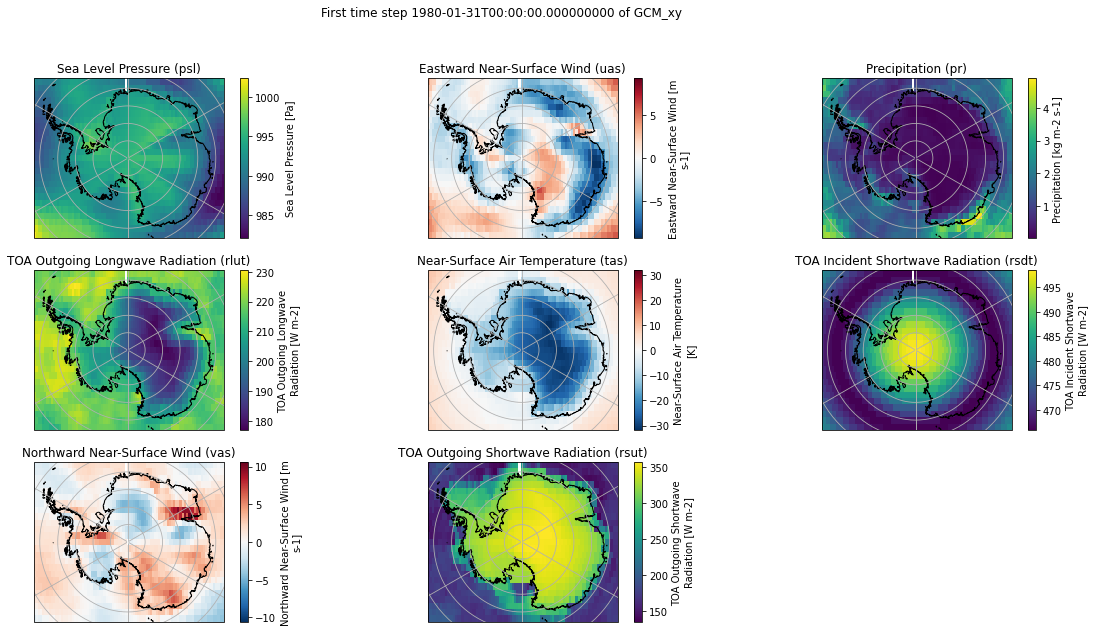

In [12]:
plotAllVar(GCM_xy, m=3, n=3, name='GCM_xy')

## GCM like RCM
Reproject RCM xy on GCM xy grid: Creates fake GCM like outputs from RCM

In [ ]:
def MovingAverageFilter(df, size = 3):
    Smoothed = xr.Dataset(coords = df.coords, attrs = df.attrs)
    vars_ = list(df.data_vars)
    for var in vars_:
        smoothed = ndimage.uniform_filter(df[var].values, size=size, mode='nearest')
        Smoothed[var] = xr.Variable(dims = df[var].dims, 
                                data = smoothed, 
                                attrs = df[var].attrs)
        
    return Smoothed

In [ ]:
# RCM xy:
# open from google cloud
fileGC = f'MAR(ACCESS1-3)_monthly.nc'
# upload to GC:
print(f'Downloading {fileGC} from GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
downloadFileFromGC(pathGC, '', fileGC)

RCM_xy = xr.open_dataset(fileGC)
os.remove(fileGC)
RCM_xy

In [ ]:
# Compare resolutions
print("GCM with crs x/y:\n----------------\n")
print_raster(GCM_xy.tas)
print("RCM with crs x/y:\n----------------\n")
print_raster(RCM_xy.TT)

In [ ]:
# Reproject
vars_ = list(RCM_xy.keys())
GCM_like = xr.Dataset()
dim = ('time', 'y', 'x')
for var in vars_:
    GCM_like[var] = xr.Variable(dims = dim, 
                                data = RCM_xy[var].rio.reproject_match(GCM_xy.tas), 
                                attrs = RCM_xy[var].attrs)
GCM_like = GCM_like.assign_coords(RCM_xy[var].rio.reproject_match(GCM_xy.tas).coords)

# Smooth with moving average:
GCM_like_smoothed = MovingAverageFilter(GCM_like)
GCM_like_smoothed

In [ ]:
# Save file
fileGC = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'

# save file locally:
GCM_like_smoothed.attrs['crs'] = 3031
GCM_like_smoothed.to_netcdf(fileGC)

# upload to GC:
print(f'Uploading {fileGC} to GC...')
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
uploadFileToGC(pathGC, fileGC)
os.remove(fileGC)

In [ ]:
# Read GCM like RCM:
fileGC = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'

pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/RCM/'
downloadFileFromGC(pathGC, '', fileGC)

GCMLike = xr.open_dataset(fileGC)
os.remove(fileGC)
GCMLike

In [ ]:
print("GCM_like with crs x/y:\n----------------\n")
print_raster(GCM_like_smoothed)

In [ ]:
plotAllVar(GCM_like, m=3, n=3, name='GCM like RCM')

In [ ]:
plotAllVar(GCM_like_smoothed, m=3, n=3, name='GCM like smoothed RCM')

In [ ]:
plotAllVar(RCM_xy, m=3, n=3, name='RCM_xy')

In [ ]:
plotAllVar(GCM_xy, m=3, n=3, name='GCM_xy')